# Battle of Neighborhoods: New York and Toronto

## Introduction



A European B2B company who does business with various venues to supply accessories across big cities wants to launch its business in North America. They ha chosen New York and Toronto as their two starting point. They need to know:

- The type of venue distribution across Toronto to create cluster of Neighborhoods to identify market locations so that delivary system can be modified.
- Overall financial condition distribution of the people there to predict the buying power of the future cutomers.

They want to see how they can segment the two cities and if they can find similar segments.

At first, various location data will be collected and cleaned as necessary. Then venues data will be imported and cluster analysis will be used to making cluster of venues of two cities and compare them with each other. Then, the income and population densities across different boroughs of the cities will be compared.


**Importing Necessary Packages**

In [2]:
!pip install wikipedia
!pip install folium
!pip install geocoder

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import wikipedia as wp

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

  Stored in directory: /home/jupyterlab/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia
    100% |████████████████████████████████| 102kB 12.5MB/s 
Libraries imported.


**Importing Toronto Geospatial data from url**

In [105]:
a = pd.read_csv('https://cocl.us/Geospatial_data')
print('data read')

data read


In [106]:
gdf = pd.DataFrame(a)

gdf.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


**Modifying and combining Geospatial data with Neighborhood data from wikipedia to get final Toronto Neighbourhood dataframe**

In [107]:
import pandas as pd
import wikipedia as wp
 
#Get the html source
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
dfr = pd.read_html(html)[0]
df = pd.DataFrame(dfr)

df.drop(df.index[:1], inplace=True)
column_names = ['PostalCode','Borough', 'Neighborhood']
df.columns=['PostalCode','Borough', 'Neighborhood']

df.drop(df[df['Borough'] == 'Not assigned'].index, inplace = True)  #Filling out 'Not assigned Neighborhoods'

df['Neighborhood'][df[df['Neighborhood'] == 'Not assigned'].index] = df['Borough'][df[df['Neighborhood'] == 'Not assigned'].index]

df.Neighborhood = df.Neighborhood.astype(str)
result = df.groupby('PostalCode',sort=False, as_index=False).agg(lambda x: ', '.join(set(x.dropna())))

postcode = list(df['PostalCode'].unique())

dfn = df.drop_duplicates('PostalCode')

borough = list(dfn['Borough'])

new = {'PostalCode':postcode,'Borough':borough,'Neighborhood':result['Neighborhood']}
newdf = pd.DataFrame(new)

In [108]:
cols = newdf.columns.tolist()
cols = cols[-1:] + cols[:-1]
dftor = newdf[cols]

dftor.shape

(103, 3)

In [109]:
final = dftor

In [110]:
lat = []
long=[]
for i in dftor['PostalCode']:
    b = gdf['Latitude'][gdf[gdf['Postal Code']== i].index]
    c = gdf['Longitude'][gdf[gdf['Postal Code']== i].index]
    lat.append(list(b)[0])
    long.append(list(c)[0])

In [111]:
final['Latitude']=lat
final['Longitude']=long

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [112]:
tor_n = final

print(tor_n.shape)
tor_n.head()

(103, 5)


,Neighborhood,PostalCode,Borough,Latitude,Longitude
0,Parkwoods,M3A,North York,43.753259,-79.329656
1,Victoria Village,M4A,North York,43.725882,-79.315572
2,"Harbourfront, Regent Park",M5A,Downtown Toronto,43.654260,-79.360636
3,"Lawrence Manor, Lawrence Heights",M6A,North York,43.718518,-79.464763
4,Queen's Park,M7A,Queen's Park,43.662301,-79.389494


In [113]:
toronto_datas = tor_n[['Borough', 'Neighborhood', 'Latitude', 'Longitude']]

**Importing New York geospatial data**

In [114]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


**Modification of Geospatial data to make the New York Neighborhood dataframe**

In [115]:
with open('newyork_data.json') as json_data:
    newyork_nigh = json.load(json_data)

In [116]:
ny_neigh = newyork_nigh['features']

In [117]:
# define the dataframe columns
ny_nighcolumn = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
ny_neighborhoods = pd.DataFrame(columns=ny_nighcolumn)

In [118]:
for data in ny_neigh:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_neighborhoods = ny_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [119]:
ny_neighborhoods.shape

(306, 4)

In [120]:
ny_n = ny_neighborhoods[['Borough','Neighborhood','Latitude', 'Longitude']]
ny_n.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


**Foursquare API credentials**

In [23]:
CLIENT_ID = 'VVIUN3HUJG03IB1RLKTJ2RGXFC4CKMT3IVTZ2JCV0RAOGSVR' # your Foursquare ID
CLIENT_SECRET = 'OREBLVLLZGUGDSBXPP4LGSSK21LXQ0TYTH5PTZOOMHQSAYON' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: VVIUN3HUJG03IB1RLKTJ2RGXFC4CKMT3IVTZ2JCV0RAOGSVR
CLIENT_SECRET:OREBLVLLZGUGDSBXPP4LGSSK21LXQ0TYTH5PTZOOMHQSAYON


**Constructing a function that will import venues data using Foursquare APi and neighborhood location and convert all the data into a dataframe**

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Getting Toronto venues data with neighborhoods**

In [25]:
toronto_venues = getNearbyVenues(names=tor_n['Neighborhood'],
                                   latitudes=tor_n['Latitude'],
                                   longitudes=tor_n['Longitude']
                                  )

Parkwoods
Victoria Village
Harbourfront, Regent Park
Lawrence Manor, Lawrence Heights
Queen's Park
Islington Avenue
Malvern, Rouge
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Glencairn
Princess Gardens, West Deane Park, Martin Grove, Islington, Cloverdale
Highland Creek, Rouge Hill, Port Union
Don Mills South, Flemingdon Park
Woodbine Heights
St. James Town
Humewood-Cedarvale
Markland Wood, Old Burnhamthorpe, Bloordale Gardens, Eringate
Morningside, Guildwood, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Downsview North, Wilson Heights, Bathurst Manor
Thorncliffe Park
Adelaide, Richmond, King
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Oriole, Henry Farm
Northwood Park, York University
East Toronto
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
Ionview, Kennedy Park, East Birchmount Park
Bayview Village
CFB Toronto, Downsview East
River

In [26]:
toronto_venues.to_csv('toronto_venues.csv')

**Getting New York venues data with neighborhoods**

In [27]:
newyork_venues = getNearbyVenues(names=ny_n['Neighborhood'],
                                   latitudes=ny_n['Latitude'],
                                   longitudes=ny_n['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [28]:
newyork_venues.to_csv('newyork_venues.csv')

**Checking tha data of Toronto and New York venues**

In [138]:
toronto_venues = pd.read_csv('toronto_venues.csv')
print(toronto_venues.shape)
toronto_venues.head()

(2245, 8)


,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,3,Parkwoods,43.753259,-79.329656,TTC stop - 44 Valley Woods,43.755402,-79.333741,Bus Stop
4,4,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena


In [23]:
toronto_venues.to_csv('toronto_venues.csv')

In [139]:
newyork_venues = pd.read_csv('newyork_venues.csv')
print(newyork_venues.shape)
newyork_venues.head()

(10296, 8)


,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,2,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant
3,3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,4,Wakefield,40.894705,-73.847201,Dunkin Donuts,40.890459,-73.849089,Donut Shop


In [26]:
newyork_venues.to_csv('newyork_venues.csv')

**Getting the number of unique categories of venues from venues data of Toronto and New york**

In [140]:
print('There are {} uniques categories in Toronto.'.format(len(toronto_venues['Venue Category'].unique())))

There are 275 uniques categories in Toronto.


In [141]:
print('There are {} uniques categories in NewYork.'.format(len(newyork_venues['Venue Category'].unique())))

There are 422 uniques categories in NewYork.


**Counting and Grouping venus by Neighborhoods of Toronto and New York**

In [142]:
toronto_venues.groupby('Neighborhood').count()

,Unnamed: 0,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
"Adelaide, Richmond, King",100,100,100,100,100,100,100
Agincourt,4,4,4,4,4,4,4
"Agincourt North, Steeles East, L'Amoreaux East, Milliken",2,2,2,2,2,2,2
"Alderwood, Long Branch",10,10,10,10,10,10,10
Bayview Village,4,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24,24
Berczy Park,55,55,55,55,55,55,55
Business Reply Mail Processing Centre 969 Eastern,17,17,17,17,17,17,17
"CFB Toronto, Downsview East",3,3,3,3,3,3,3


In [143]:
newyork_venues.groupby('Neighborhood').count()

,Unnamed: 0,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Allerton,29,29,29,29,29,29,29
Annadale,10,10,10,10,10,10,10
Arden Heights,5,5,5,5,5,5,5
Arlington,5,5,5,5,5,5,5
Arrochar,19,19,19,19,19,19,19
Arverne,17,17,17,17,17,17,17
Astoria,100,100,100,100,100,100,100
Astoria Heights,14,14,14,14,14,14,14
Auburndale,17,17,17,17,17,17,17


**ENCODING data for Cluster analysis** (quantifying the categories)

In [144]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [145]:
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns1 = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns1]

newyork_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,Airport Tram,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outd

In [146]:
toronto_onehot.shape

(2245, 275)

In [147]:
newyork_onehot.shape

(10296, 422)

**Standardizing the dataset**

In [148]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, Richmond, King",0.0,0.01,0.0,0.0,0.0,0.0,0.0,

In [149]:
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean().reset_index()
newyork_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,Airport Tram,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outd

In [150]:
print(toronto_grouped.shape)
print(newyork_grouped.shape)

(100, 275)
(302, 422)


**Filtering out the most common 20 venue category**

In [49]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [162]:
num_top_venues = 20 #Number of top venues we want to take into account

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))



In [163]:
# create a new dataframe
t_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
t_neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    t_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

t_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,"Adelaide, Richmond, King",Coffee Shop,Bar,Café,Thai Restaurant,Steakhouse,Hotel,Sushi Restaurant,Bakery,Burger Joint,American Restaurant,Restaurant,Cosmetics Shop,Gym,Concert Hall,Salad Place,Breakfast Spot,Japanese Restaurant,Pizza Place,Gastropub,Asian Restaurant
1,Agincourt,Lounge,Clothing Store,Sandwich Place,Breakfast Spot,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Deli / Bodega,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Department Store,Women's Store,College Auditorium
2,"Agincourt North, Steeles East, L'Amoreaux East...",Park,Playground,Dog Run,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant,Curling Ice,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Dance Studio,Cupcake Shop,Ethiopian Restaurant,Cuban Restaurant
3,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Gym,Dance Studio,Skating Rink,Pharmacy,Sandwich Place,Pub,Pool,Dessert Shop,Curling Ice,Deli / Bodega,Department Store,Diner,Dim Sum Restaurant,Cuban Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop
4,Bayview Village,Café,Japanese Restaurant,Chinese Restaurant,Bank,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant,Deli / Bodega,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Department Store,Dance Studio


In [164]:
t_neighborhoods_venues_sorted.shape

(100, 21)

In [165]:
# create a new dataframe
ny_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
ny_neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    ny_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

ny_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Supermarket,Spa,Chinese Restaurant,Intersection,Fried Chicken Joint,Breakfast Spot,Bus Station,Spanish Restaurant,Fast Food Restaurant,Mexican Restaurant,Electronics Store,Pharmacy,Donut Shop,Martial Arts Dojo,Discount Store,Construction & Landscaping,Playground,Dessert Shop
1,Annadale,Bakery,Restaurant,Train Station,Diner,American Restaurant,Sports Bar,Cosmetics Shop,Park,Dance Studio,Pizza Place,Eye Doctor,Exhibit,Filipino Restaurant,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Flea Market
2,Arden Heights,Pharmacy,Coffee Shop,Bus Stop,Pizza Place,Home Service,Fast Food Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Women's Store,Ethiopian Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market
3,Arlington,Intersection,Deli / Bodega,American Restaurant,Bus Stop,Grocery Store,Women's Store,Fish & Chips Shop,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Flea Market,Fish Market,Event Service,Flower Shop
4,Arrochar,Deli / Bodega,Italian Restaurant,Bus Stop,Nail Salon,Hotel,Middle Eastern Restaurant,Outdoors & Recreation,Bagel Shop,Sandwich Place,Athletics & Sports,Taco Place,Pizza Place,Mediterranean Restaurant,Supermarket,Cosmetics Shop,Food Truck,Fast Food Restaurant,Eye Doctor,Factory,Falafel Restaurant


In [166]:
ny_neighborhoods_venues_sorted.shape

(302, 21)

**KMeans Clustering by setting the number of clusters. In this case cluster number is taken as 5**

For Toronto:

In [158]:
# set number of clusters
t_kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans_tor = KMeans(n_clusters=t_kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_tor.labels_[0:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 4, 4], dtype=int32)

In [159]:
a = np.bincount(kmeans_tor.labels_)
a
for i in a:
    print(i/sum(a))

0.83
0.02
0.01
0.01
0.13


For New York:

In [160]:
# set number of clusters
ny_kclusters = 5

newyork_grouped_clustering = newyork_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans_ny = KMeans(n_clusters=ny_kclusters, random_state=0).fit(newyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_ny.labels_[0:10]

array([3, 0, 3, 2, 2, 3, 0, 0, 0, 3], dtype=int32)

In [161]:
b = np.bincount(kmeans_ny.labels_)
b 
for i in b:
    print(round(i/sum(b),5))

0.45033
0.00662
0.12583
0.41391
0.00331


**Adding Cluster Labels to each neighborhoods of the two cities' dataframe**

In [122]:
# add clustering labels
t_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_tor.labels_)

toronto_merged = toronto_datas

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(t_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,4.0,Park,Fast Food Restaurant,Food & Drink Shop,Bus Stop,Women's Store,Diner,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Dog Run,Discount Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Dance Studio,Curling Ice,Empanada Restaurant
1,North York,Victoria Village,43.725882,-79.315572,0.0,Coffee Shop,Intersection,Hockey Arena,Portuguese Restaurant,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Dance Studio,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Deli / Bodega,Cupcake Shop,Curling Ice
2,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,0.0,Coffee Shop,Café,Bakery,Pub,Park,Breakfast Spot,Theater,Mexican Restaurant,Ice Cream Shop,Historic Site,Hotel,Gym / Fitness Center,Italian Restaurant,French Restaurant,Performing Arts Venue,Restaurant,Health Food Store,Electronics Store,Farmers Market,Event Space
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Clothing Store,Shoe Store,Furniture / Home Store,Event Space,Gift Shop,Miscellaneous Shop,Boutique,Vietnamese Restaurant,Coffee Shop,Accessories Store,Drugstore,Donut Shop,Dance Studio,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store
4,Queen's Park,Queen's Park,43.662301,-79.389494,0.0,Coffee Shop,Diner,Gym,Burger Joint,Japanese Restaurant,Yoga Studio,Fast Food Restaurant,Creperie,Portuguese Restaurant,Café,Bar,Burrito Place,Italian Restaurant,Arts & Crafts Store,Smoothie Shop,Music Venue,Sandwich Place,Mexican Restaurant,Sushi Restaurant,Seafood Restaurant


In [124]:
# add clustering labels
ny_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_ny.labels_)

newyork_merged = ny_n

# merge toronto_grouped with newyork_data to add latitude/longitude for each neighborhood
newyork_merged = newyork_merged.join(ny_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

newyork_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,3,Laundromat,Pharmacy,Food Truck,Caribbean Restaurant,Dessert Shop,Ice Cream Shop,Donut Shop,Sandwich Place,Fast Food Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Women's Store,Field,Ethiopian Restaurant,Filipino Restaurant
1,Bronx,Co-op City,40.874294,-73.829939,3,Bus Station,Pizza Place,Fast Food Restaurant,Mattress Store,Park,Restaurant,Cosmetics Shop,Ice Cream Shop,Baseball Field,Pharmacy,Discount Store,Grocery Store,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Women's Store,Filipino Restaurant
2,Bronx,Eastchester,40.887556,-73.827806,3,Bus Station,Caribbean Restaurant,Diner,Deli / Bodega,Bowling Alley,Metro Station,Chinese Restaurant,Bakery,Seafood Restaurant,Fast Food Restaurant,Pizza Place,Donut Shop,Platform,Juice Bar,Convenience Store,Cosmetics Shop,Bus Stop,Food,Food Truck,Food Stand
3,Bronx,Fieldston,40.895437,-73.905643,0,River,Athletics & Sports,Playground,Plaza,Women's Store,Field,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,English Restaurant,Fish & Chips Shop,Fish Market,Flea Market
4,Bronx,Riverdale,40.890834,-73.912585,0,Park,Bank,Plaza,Food Truck,Home Service,Playground,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Women's Store,Ethiopian Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market


**Showing neighborhood clusters in a map**

Neighborhood cluster for Toronto:

In [52]:
toronto_merged.dropna(inplace =True)

In [53]:
t_latitude = 43.6532
t_longitude = -79.3832

In [135]:
# create map
t_map_clusters = folium.Map(location=[t_latitude, t_longitude], zoom_start=10.5)

# set color scheme for the clusters
x = np.arange(t_kclusters)
ys = [i + x + (i*x)**2 for i in range(t_kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lats, lons, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lats, lons],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(t_map_clusters)


t_map_clusters.save('t_map_cluster.html', dpi = 300) #saving the map as image
t_map_clusters

In [177]:
nyc4.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Wakefield,Laundromat,Pharmacy,Food Truck,Caribbean Restaurant,Dessert Shop,Ice Cream Shop,Donut Shop,Sandwich Place,Fast Food Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Women's Store,Field,Ethiopian Restaurant,Filipino Restaurant
1,Co-op City,Bus Station,Pizza Place,Fast Food Restaurant,Mattress Store,Park,Restaurant,Cosmetics Shop,Ice Cream Shop,Baseball Field,Pharmacy,Discount Store,Grocery Store,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Women's Store,Filipino Restaurant
2,Eastchester,Bus Station,Caribbean Restaurant,Diner,Deli / Bodega,Bowling Alley,Metro Station,Chinese Restaurant,Bakery,Seafood Restaurant,Fast Food Restaurant,Pizza Place,Donut Shop,Platform,Juice Bar,Convenience Store,Cosmetics Shop,Bus Stop,Food,Food Truck,Food Stand
5,Kingsbridge,Pizza Place,Bar,Supermarket,Sandwich Place,Discount Store,Mexican Restaurant,Bakery,Latin American Restaurant,Donut Shop,Pharmacy,Fried Chicken Joint,Chinese Restaurant,Liquor Store,Spanish Restaurant,Deli / Bodega,Mattress Store,Candy Store,Gourmet Shop,Café,Beer Bar
6,Marble Hill,Discount Store,Sandwich Place,Coffee Shop,Yoga Studio,Steakhouse,Supplement Shop,Big Box Store,Tennis Stadium,Gym,Shoe Store,Bank,Donut Shop,Pizza Place,Seafood Restaurant,Video Game Store,American Restaurant,Diner,Ice Cream Shop,Department Store,Deli / Bodega


In [123]:
torc1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
torc2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
torc3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
torc4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
torc5 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

print('Clusters of New York and their neighborhoods:')
print('Cluster 1: ', 'Number of Neighborhoods:' ,torc1.shape[0] , torc1['Neighborhood'].tolist(), sep='\n')
print('Cluster 2: ', 'Number of Neighborhoods:' ,torc2.shape[0] , torc2['Neighborhood'].tolist(), sep='\n')
print('Cluster 3: ', 'Number of Neighborhoods:' ,torc3.shape[0] , torc3['Neighborhood'].tolist(), sep='\n')
print('Cluster 4: ', 'Number of Neighborhoods:' ,torc4.shape[0] , torc4['Neighborhood'].tolist(), sep='\n')
print('Cluster 5: ', 'Number of Neighborhoods:' ,torc5.shape[0] , torc5['Neighborhood'].tolist(), sep='\n')

Clusters of New York and their neighborhoods:
Cluster 1: 
Number of Neighborhoods:
83
['Victoria Village', 'Harbourfront, Regent Park', 'Lawrence Manor, Lawrence Heights', "Queen's Park", 'Don Mills North', 'Woodbine Gardens, Parkview Hill', 'Ryerson, Garden District', 'Princess Gardens, West Deane Park, Martin Grove, Islington, Cloverdale', 'Highland Creek, Rouge Hill, Port Union', 'Don Mills South, Flemingdon Park', 'Woodbine Heights', 'St. James Town', 'Humewood-Cedarvale', 'Markland Wood, Old Burnhamthorpe, Bloordale Gardens, Eringate', 'Morningside, Guildwood, West Hill', 'The Beaches', 'Berczy Park', 'Woburn', 'Leaside', 'Central Bay Street', 'Christie', 'Cedarbrae', 'Hillcrest Village', 'Downsview North, Wilson Heights, Bathurst Manor', 'Thorncliffe Park', 'Adelaide, Richmond, King', 'Dovercourt Village, Dufferin', 'Fairview, Oriole, Henry Farm', 'Northwood Park, York University', 'Harbourfront East, Toronto Islands, Union Station', 'Little Portugal, Trinity', 'Ionview, Kennedy 

Neighborhood cluster for New York:

In [125]:
newyork_merged.dropna(inplace =True)

In [126]:
ny_latitude = 40.730610
ny_longitude = -73.935242

In [127]:
#create map
ny_map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10.25)

# set color scheme for the clusters
x = np.arange(ny_kclusters)
ys = [i + x + (i*x)**2 for i in range(ny_kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lats, lons, poi, cluster in zip(newyork_merged['Latitude'], newyork_merged['Longitude'], newyork_merged['Neighborhood'], newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lats, lons],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(ny_map_clusters)
       

ny_map_clusters.save('ny_map_cluster.html') #saving the map as image        
ny_map_clusters

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [129]:
nyc1 = newyork_merged.loc[newyork_merged['Cluster Labels'] == 0, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]
nyc2 = newyork_merged.loc[newyork_merged['Cluster Labels'] == 1, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]
nyc3 = newyork_merged.loc[newyork_merged['Cluster Labels'] == 2, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]
nyc4 = newyork_merged.loc[newyork_merged['Cluster Labels'] == 3, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]
nyc5 = newyork_merged.loc[newyork_merged['Cluster Labels'] == 4, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

print('Clusters of New York and their neighborhoods:')
print('Cluster 1: ', 'Number of Neighborhoods:' ,nyc1.shape[0] , nyc1['Neighborhood'].tolist(), sep='\n')
print('Cluster 2: ', 'Number of Neighborhoods:' ,nyc2.shape[0] , nyc2['Neighborhood'].tolist(), sep='\n')
print('Cluster 3: ', 'Number of Neighborhoods:' ,nyc3.shape[0] , nyc3['Neighborhood'].tolist(), sep='\n')
print('Cluster 4: ', 'Number of Neighborhoods:' ,nyc4.shape[0] , nyc4['Neighborhood'].tolist(), sep='\n')
print('Cluster 5: ', 'Number of Neighborhoods:' ,nyc5.shape[0] , nyc5['Neighborhood'].tolist(), sep='\n')

Clusters of New York and their neighborhoods:
Cluster 1: 
Number of Neighborhoods:
140
['Fieldston', 'Riverdale', 'Williamsbridge', 'City Island', 'Port Morris', 'Clason Point', 'Pelham Bay', 'Olinville', 'Bay Ridge', 'Bensonhurst', 'Greenpoint', 'Brighton Beach', 'Sheepshead Bay', 'East Flatbush', 'Windsor Terrace', 'Prospect Heights', 'Brownsville', 'Williamsburg', 'Bushwick', 'Bedford Stuyvesant', 'Brooklyn Heights', 'Cobble Hill', 'Carroll Gardens', 'Red Hook', 'Gowanus', 'Fort Greene', 'Park Slope', 'Mill Island', 'Coney Island', 'Dyker Heights', 'Gerritsen Beach', 'Clinton Hill', 'Sea Gate', 'Downtown', 'Boerum Hill', 'Prospect Lefferts Gardens', 'Bergen Beach', 'East Williamsburg', 'North Side', 'South Side', 'Fort Hamilton', 'Chinatown', 'Washington Heights', 'Inwood', 'Hamilton Heights', 'Manhattanville', 'Central Harlem', 'East Harlem', 'Upper East Side', 'Yorkville', 'Lenox Hill', 'Roosevelt Island', 'Upper West Side', 'Lincoln Square', 'Clinton', 'Midtown', 'Murray Hill', '

**Importing the Average Income and population data for New York and cleaning the data**

In [3]:
#Get the html source
html1 = wp.page("Boroughs of New York City").html().encode("UTF-8")
dfny = pd.read_html(html1)[0]
dfn = pd.DataFrame(dfny)

dfn.drop(dfn.index[5:], inplace=True)

dfn.head()

New York City's five boroughsvte                               \
                      Jurisdiction                   Population   
                           Borough    County Estimate (2017)[3]   
0                        The Bronx     Bronx            1471160   
1                         Brooklyn     Kings            2648771   
2                        Manhattan  New York            1664727   
3                           Queens    Queens            2358582   
4                    Staten Island  Richmond             479458   

                                                                \
  Gross Domestic Product                    Land area            
        billions(US$)[4] per capita(US$) square miles squarekm   
0                 28.787           19570        42.10   109.04   
1                 63.303           23900        70.82   183.42   
2                629.682          378250        22.83    59.13   
3                 73.842           31310       108.53   281.09   
4                 11.249           23460        58.37   151.18   

                                    
           Density                  
  persons / sq. mi persons /sq. km  
0            34653           13231  
1            37137           14649  
2            72033           27826  
3            21460            8354  
4             8112            3132

In [4]:
dfn = dfn.ix[:,[0,2,4,8]]
column_names1 = ['Borough','Population','Average Income','Population Density']
dfn.columns= column_names1

dfn

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,Borough,Population,Average Income,Population Density
0,The Bronx,1471160,19570,13231
1,Brooklyn,2648771,23900,14649
2,Manhattan,1664727,378250,27826
3,Queens,2358582,31310,8354
4,Staten Island,479458,23460,3132


In [5]:
dfn.index = range(5)
dfn

,Borough,Population,Average Income,Population Density
0,The Bronx,1471160,19570,13231
1,Brooklyn,2648771,23900,14649
2,Manhattan,1664727,378250,27826
3,Queens,2358582,31310,8354
4,Staten Island,479458,23460,3132


In [6]:
dfn['Borough'] = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

In [7]:
dfn['Population']=dfn['Population'].astype(int)
dfn['Average Income'] = dfn['Average Income'].astype(int)
dfn['Population Density'] = dfn['Population Density'].astype(int)
dfn.dtypes

Borough               object
Population             int64
Average Income         int64
Population Density     int64
dtype: object

**Importing the Average Income and Population density data of toronto and modifying them**

In [8]:
html2 = wp.page("Demographics of Toronto neighbourhoods").html().encode("UTF-8")
dft = pd.read_html(html2)[1]
dft = pd.DataFrame(dft)

dft.head()

,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map
0,Toronto CMA Average,NaN,All,5113149,5903.63,866,9.0,40704,10.6,11.4,NaN,NaN,NaN
1,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN
2,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN
3,Alexandra Park,OCoT,0039.00,4355,0.32,13609,0.0,19687,13.8,28.0,Cantonese (17.9%),17.9% Cantonese,NaN
4,Allenby,OCoT,0140.00,2513,0.58,4333,-1.0,245592,5.2,3.4,Russian (1.4%),01.4% Russian,NaN


In [9]:
dft = dft.iloc[:,[1,3,4,7]]

In [10]:
dft.drop(dft.index[:1], inplace=True)

**Calculating data for each boroughs**

In [11]:
column_names2 = ['Borough','Population', 'Area', 'Average Income']
dft.columns = column_names2
dft.head()

,Borough,Population,Area,Average Income
1,S,44577,12.45,25750
2,E,11656,4.94,35239
3,OCoT,4355,0.32,19687
4,OCoT,2513,0.58,245592
5,NY,17318,3.51,27546


In [12]:
dft['Average Income'][64] = '45792' # an unnecessary string is inside this cell. so it has been cleaned

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
dft[['Population', 'Area', 'Average Income']] = dft[['Population', 'Area', 'Average Income']].apply(pd.to_numeric)
dft.dtypes

Borough            object
Population          int64
Area              float64
Average Income      int64
dtype: object

In [14]:
dft_1 = dft[['Borough','Population', 'Area']]

In [15]:
dft_2 = dft_1.groupby('Borough').sum().reset_index()
dft_2

,Borough,Population,Area
0,E,313772,115.09
1,EY,112054,21.05
2,NY,621068,173.44
3,OCoT,624910,93.43
4,S,600715,182.23
5,Y,143255,23.34


In [16]:
dft_2['Population'].sum()

2415774

In [17]:
dft_2['Population Density'] = dft_2['Population']/dft_2['Area']
dft_2

,Borough,Population,Area,Population Density
0,E,313772,115.09,2726.318533
1,EY,112054,21.05,5323.230404
2,NY,621068,173.44,3580.880996
3,OCoT,624910,93.43,6688.536873
4,S,600715,182.23,3296.466004
5,Y,143255,23.34,6137.746358


In [18]:
dft_2['Population Density'] = dft_2['Population Density'].astype(int)
dft_2

,Borough,Population,Area,Population Density
0,E,313772,115.09,2726
1,EY,112054,21.05,5323
2,NY,621068,173.44,3580
3,OCoT,624910,93.43,6688
4,S,600715,182.23,3296
5,Y,143255,23.34,6137


In [19]:
dft_borough = dft_2['Borough'].unique().tolist()
dft_borough

['E', 'EY', 'NY', 'OCoT', 'S', 'Y']

In [20]:
den = {}
for i in dft_borough:
    c = list(dft['Average Income'][dft[dft['Borough']==i].index].values)
    den[i] = c
    
den

{'E': [35239,
  34867,
  26610,
  36206,
  34789,
  39186,
  39738,
  80618,
  29576,
  43570,
  32004,
  37288,
  51695,
  47011,
  33415,
  80607,
  34579,
  24387,
  51398,
  28014,
  110944,
  38944,
  28955,
  41582,
  35183],
 'EY': [23021, 129904, 82670, 33517, 33172, 25340],
 'NY': [27546,
  116651,
  92319,
  34169,
  46752,
  41485,
  27156,
  314107,
  103703,
  104362,
  47515,
  30442,
  26751,
  22691,
  23471,
  35022,
  23350,
  56395,
  33465,
  222560,
  26117,
  30907,
  24297,
  46631,
  29867,
  36361,
  83853,
  27611,
  33428,
  34330,
  24333,
  34811,
  32002,
  29250,
  29657,
  27826,
  39895,
  37978,
  92099,
  24432],
 'OCoT': [19687,
  245592,
  40598,
  80827,
  55578,
  41605,
  27260,
  50398,
  23301,
  82203,
  81288,
  30556,
  37653,
  54681,
  28335,
  55735,
  80704,
  41998,
  40617,
  28311,
  27961,
  26672,
  33847,
  63282,
  63952,
  101631,
  46086,
  37614,
  35277,
  45792,
  69232,
  46437,
  28067,
  23335,
  214110,
  30886,
  31231,


In [21]:
sum(den['E'])

1076405

In [22]:
pen = {}
for i in dft_borough:
    p = list(dft['Population'][dft[dft['Borough']==i].index].values)
    pen[i] = p
    
pen

{'E': [11656,
  12565,
  8506,
  19131,
  8008,
  10775,
  4674,
  14453,
  7319,
  16508,
  16254,
  9625,
  10240,
  14198,
  10455,
  9288,
  26053,
  34996,
  17602,
  9437,
  8780,
  6207,
  16790,
  4395,
  5857],
 'EY': [8157, 2112, 13876, 17740, 52220, 17949],
 'NY': [17318,
  4384,
  6641,
  14945,
  12280,
  13298,
  8017,
  1540,
  4097,
  5504,
  21372,
  29740,
  36613,
  48003,
  21287,
  18426,
  4714,
  2790,
  18327,
  3123,
  12766,
  4327,
  14778,
  10052,
  3769,
  13750,
  12360,
  20313,
  36046,
  10427,
  8498,
  26533,
  4402,
  16615,
  17047,
  16386,
  43144,
  13732,
  17564,
  26140],
 'OCoT': [4355,
  2513,
  4787,
  13749,
  5175,
  5343,
  9039,
  11120,
  6544,
  3597,
  4906,
  5124,
  13397,
  4484,
  8781,
  23727,
  15165,
  7262,
  6378,
  8497,
  9875,
  17240,
  21440,
  4642,
  548,
  24056,
  3821,
  8240,
  9007,
  5906,
  14368,
  22746,
  6666,
  3740,
  6653,
  23567,
  7917,
  5013,
  6494,
  4474,
  6524,
  28367,
  3968,
  571,
  2719,

In [23]:
ave = {}
for i in dft_borough:
    v = []
    for k in range(0, len(den[i])):
        v.append(den[i][k]*pen[i][k])
    u = sum(v)/sum(pen[i])
    ave[i] = u
    
ave

{'E': 41251.089338755526,
 'EY': 39185.83490995413,
 'NY': 38537.489337721476,
 'OCoT': 53401.50649693556,
 'S': 28806.09824958591,
 'Y': 32430.883243167777}

In [24]:
dft_2['Average Income'] = np.nan
for i in dft_2['Borough']:
    dft_2['Average Income'][dft_2[dft_2['Borough']==i].index] = int(ave[i])

dft_2

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Borough,Population,Area,Population Density,Average Income
0,E,313772,115.09,2726,41251.0
1,EY,112054,21.05,5323,39185.0
2,NY,621068,173.44,3580,38537.0
3,OCoT,624910,93.43,6688,53401.0
4,S,600715,182.23,3296,28806.0
5,Y,143255,23.34,6137,32430.0


In [25]:
dft_2['Borough'] = ['Etobicoke', 'East York', 'North York', 'Old City of Toronto', 'Scarborough', 'York']
dft_2

,Borough,Population,Area,Population Density,Average Income
0,Etobicoke,313772,115.09,2726,41251.0
1,East York,112054,21.05,5323,39185.0
2,North York,621068,173.44,3580,38537.0
3,Old City of Toronto,624910,93.43,6688,53401.0
4,Scarborough,600715,182.23,3296,28806.0
5,York,143255,23.34,6137,32430.0


**Visualizing population Density and Average Income data of Toronto and New York with column chart**

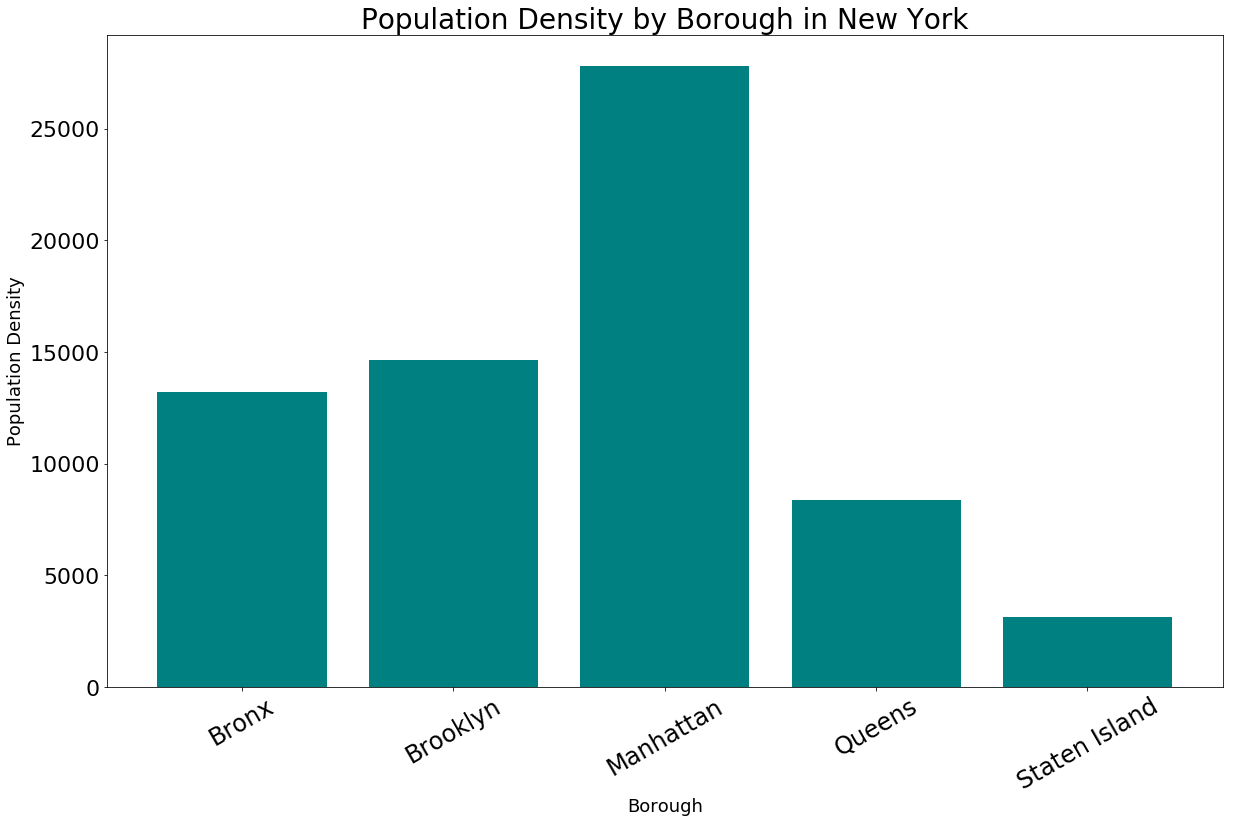

In [32]:
plt.figure(figsize = (20,12))
plt.bar(dfn['Borough'], dfn['Population Density'], color = 'teal')
plt.title("Population Density by Borough in New York", fontsize = '28')
plt.xlabel('Borough', fontsize = '18')
plt.ylabel('Population Density', fontsize = '18')
plt.xticks(fontsize='24', rotation ='30')
plt.yticks(fontsize='22')
plt.savefig('pdny.jpg')
plt.show()

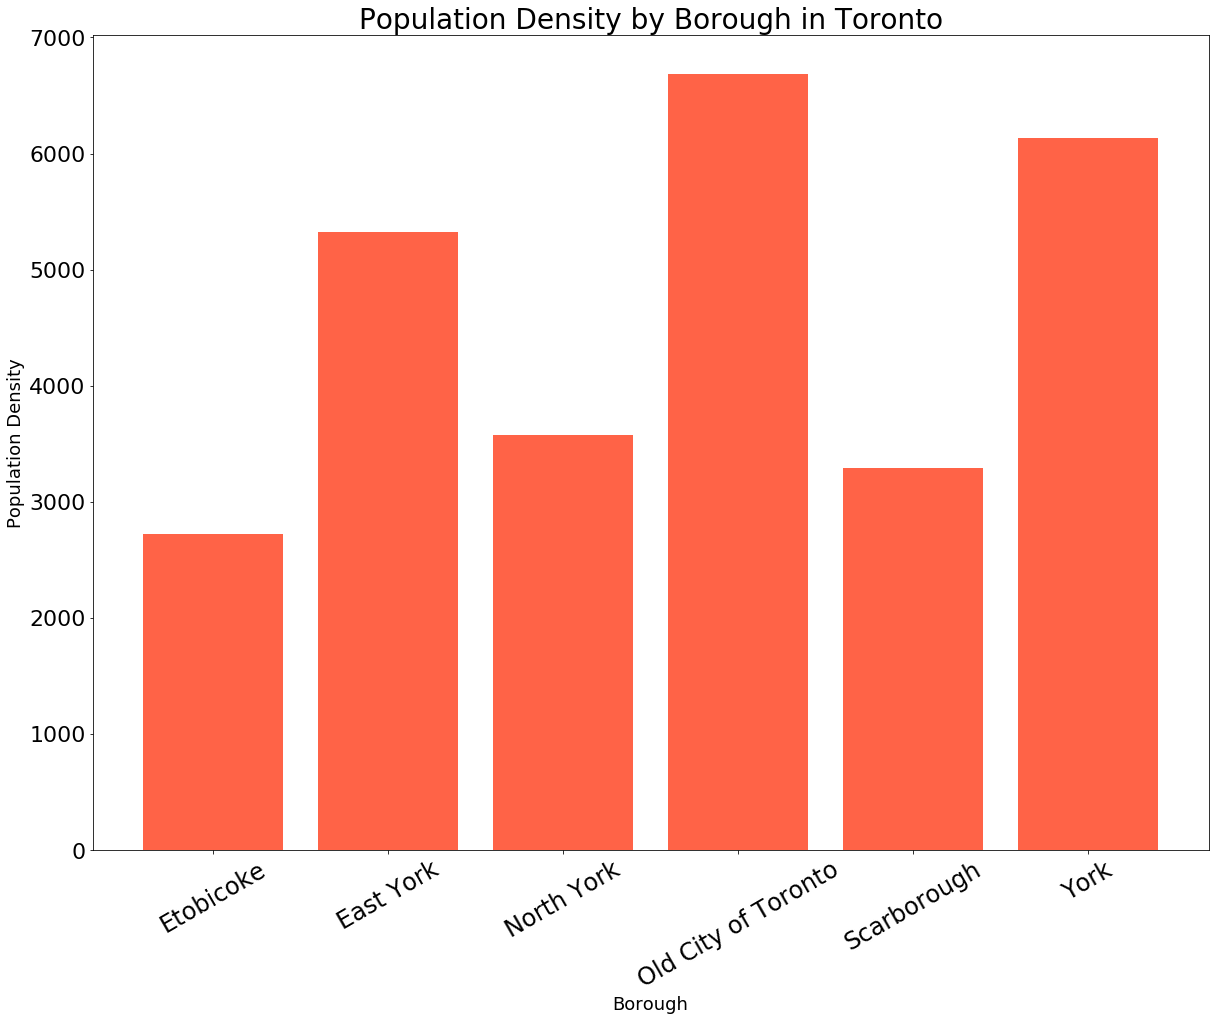

In [37]:
plt.figure(figsize = (20,15))
plt.bar(dft_2['Borough'], dft_2['Population Density'], color = 'tomato')
plt.title("Population Density by Borough in Toronto", fontsize = '28')
plt.xlabel('Borough', fontsize = '18')
plt.ylabel('Population Density', fontsize = '18')
plt.xticks(fontsize='24', rotation ='30')
plt.yticks(fontsize='22')
plt.savefig('pdtor.jpg')
plt.show()

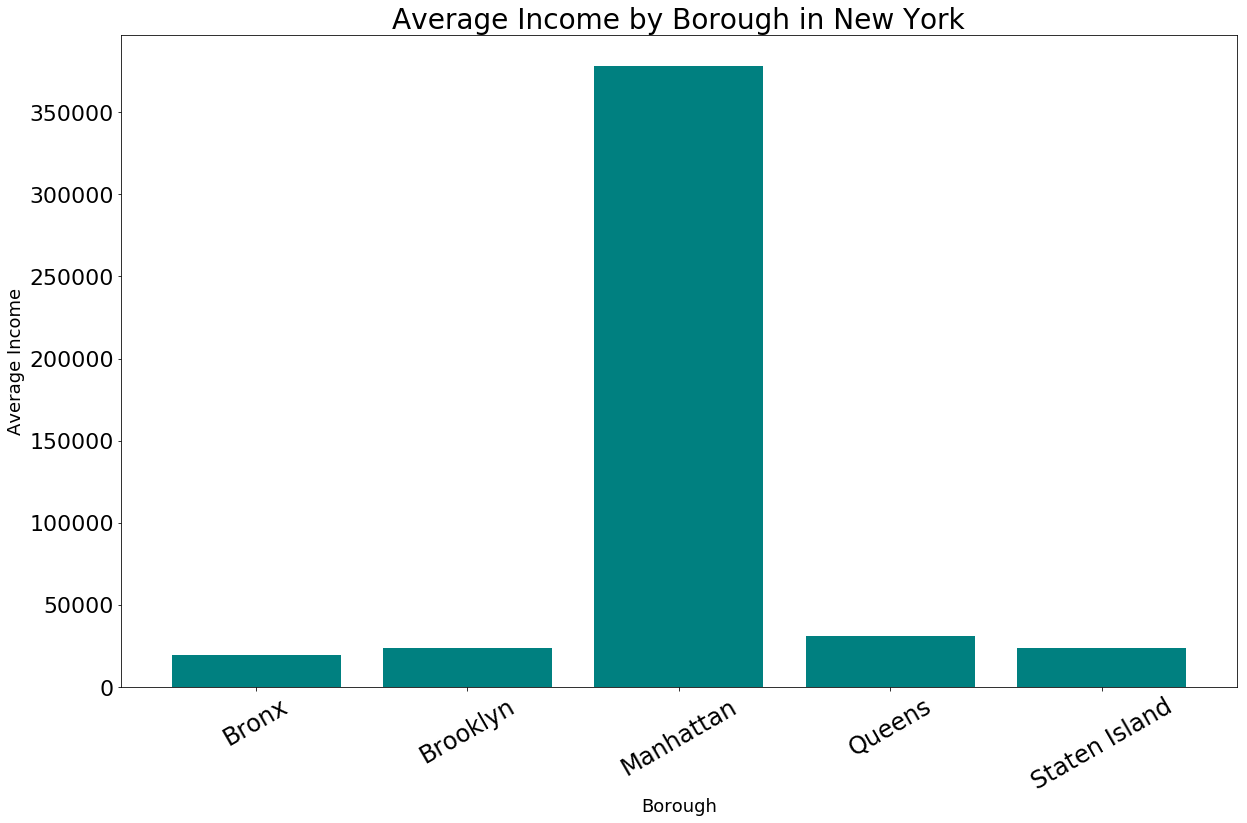

In [39]:
plt.figure(figsize = (20,12))
plt.bar(dfn['Borough'], dfn['Average Income'], color = 'teal')
plt.title("Average Income by Borough in New York", fontsize = '28')
plt.xlabel('Borough', fontsize = '18')
plt.ylabel('Average Income', fontsize = '18')
plt.xticks(fontsize='24', rotation ='30')
plt.yticks(fontsize='22')
plt.savefig('ainy.jpg')
plt.show()

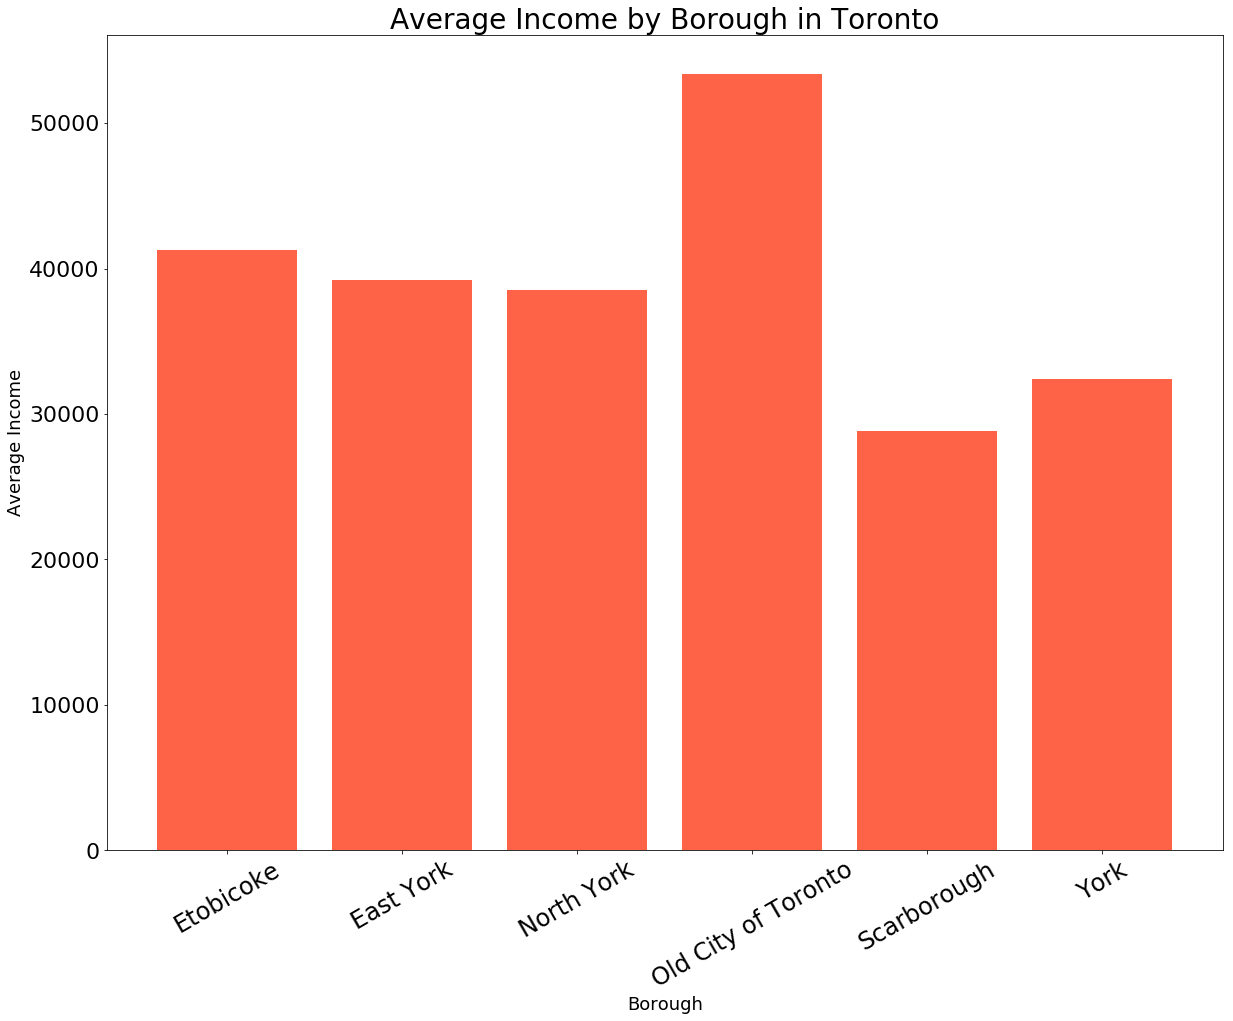

In [40]:
plt.figure(figsize = (20,15))
plt.bar(dft_2['Borough'], dft_2['Average Income'], color = 'tomato')
plt.title("Average Income by Borough in Toronto", fontsize = '28')
plt.xlabel('Borough', fontsize = '18')
plt.ylabel('Average Income', fontsize = '18')
plt.xticks(fontsize='24', rotation ='30')
plt.yticks(fontsize='22')
plt.savefig('aitor.jpg')
plt.show()

## Comment on the whole analysis:

From the Neighborhood cluster we see that the There is one big cluster in both Toronto and New York. All clusters each represent a customer segment area. all these are shown in the maps.

From Population data and average income distrbution we see that, 

in New York, one borough has very large population density and Average income than others. This means this borough "Manhattan" is the center of the city and different from othe boroughs. The customer segments are different from other boroughs.

In Toronto, population density of York, Old City of Toronto and East York are larger than other two boroughs. The average income disribution of the boroughs are much uniform d thee is not much different with Old City of Toronto has slightly higher income than the rest. So, overall the customer segment are quite similar accordeing to their density and income.